In [1]:
import numpy as np
from scipy.stats import multiscale_graphcorr
from scipy._lib._util import MapWrapper
import warnings

In [21]:
def k_sample_test(X, y,score_func="mgc"):
    """Compute the multivariate independence test statisitic for the provided sample.
    Read more in the :ref:`User Guide <multivariate_feature_selection>`.
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        The set of regressors that will be tested sequentially.
    y : ndarray of shape (n_samples,)
        The target vector.
    score_func : string that refers to a k_sample multivariate independence test from scipy
                The default and only existing test is multiscale graph correlation.
    Returns
    -------
    stat : float that refers to the computed k_sample test statistic
    """
    k_array = np.unique(y)
    matrices = []
    for i in k_array:
        indices = np.where(y == i)[0] 
        if len(X.shape) == 1:
            xi = X[indices]
        else:
            xi = X[indices,:]
        matrices.append(xi)
    X = np.concatenate(matrices)
    vs = []
    for i in range(len(np.unique(y))):
        n = matrices[i].shape[0]
        encode = np.zeros(shape=(n, len(matrices)))
        encode[:, i] = np.ones(shape=n)
        vs.append(encode)
    y = np.concatenate(vs)
    warnings.filterwarnings("ignore")
    mgc = multiscale_graphcorr(X,y,reps = 0)
    stat = mgc.stat #mgc case
    return(stat)

In [70]:
def fit_transform(X,y,k,workers = -1): 
    features = np.arange(X.shape[1])#features of matrix X(n samples by p features, creates an array of feature indexes
    best_features = []
    while (len(best_features) < k): # outerloop to obtain up to k features 
        X_new = np.array(X)# establishes matrix of data as np array
        parallel = _Parallel(X_new=X_new, y=y,best_features = best_features)#establishes parallel operation helper class object
        with MapWrapper(workers) as mapwrapper:
            scores = list(mapwrapper(parallel, features)) #maps in parallel the parallel operation that calcs score with the iterable features list to test, with best_features already obtained
        scores_index = np.zeros((len(features),2)) #temp array
        scores_index[:,0] = features #input features as first column, all features tested(exclude best_features)
        scores_index[:,1] = scores #input scores in second column
        sorted_index = scores_index[scores_index[:, 1].argsort()] #sort by scores column
        best = sorted_index[len(scores)-1,0] #find best of the scores
        best_features.append(int(best)) #append new best feature column index 
        features = np.delete(features,np.where(features == best))
    print(best_features)
    return X_new[:,best_features] # obtain

In [20]:
class _Parallel:
    """Helper function to calculate parallel test value."""

    def __init__(self, X_new, y,best_features):
        self.X_new = X_new
        self.y = y
        self.best_features = best_features

    def __call__(self, index):
        if np.var(self.X_new[:,index]) == 0:
            stat = -1000.0
        else:   
            if len(self.best_features)==0:
                X_j =  self.X_new[:,index] #each feature from j to last feature 
                stat= k_sample_test(X_j,self.y)
            else:
                columns = self.best_features #construct array for indexing 
                columns.append(index)
                X_j = self.X_new[:,columns]#perform test with obtained features against every feature after to then obtain the best group of features with one additional feature 
                stat= k_sample_test(X_j,self.y)
        return stat

In [86]:
def fit_transform_modified(X,y,k):
    uni_best_features = univariate_best(X,y,k)
    if k <=10:
        paths = np.arange(k)
    else:       
        paths = univariate_best_test_stat(X,y,k,uni_best_features.astype(int))
        paths = np.append(paths,[0,k-2])
        paths = np.sort(paths)
    data = []
    stats = []
    bests = []
    for i in paths.astype(int):
        best_features = uni_best_features[k-1-i:]
        path_i = path_best(X,y,k,best_features)
        bests.append(path_i[1])
        data.append(path_i[0])
        stat = k_sample_test(path_i[0],y)
        stats.append(stat)
    sorted_index = np.argsort(stats)
    bests = np.array(bests)
    data = np.array(data)
    print(bests[sorted_index[len(stats)-1]])
    return data[sorted_index[len(stats)-1]]

In [29]:
def univariate_best(X,y,k,workers = -1):
    features = np.arange(X.shape[1])#features of matrix X(n samples by p features, creates an array of feature indexes
    X_new = np.array(X)
    parallel = _Parallel_1(X_new=X_new, y=y)#establishes parallel operation helper class object
    with MapWrapper(workers) as mapwrapper:
        scores = list(mapwrapper(parallel, features)) #maps in parallel the parallel operation that calcs score 
    scores_index = np.argsort(scores)
    return scores_index[len(scores)-k:]

In [30]:
def univariate_best_test_stat(X,y,k,uni_best_features,workers = -1):
    indices = np.arange(k)
    X_new = np.array(X)
    parallel = _Parallel_2(X_new=X_new, y=y, uni_best_features = uni_best_features, k = k)#establishes parallel operation helper class object
    with MapWrapper(workers) as mapwrapper:
        scores = list(mapwrapper(parallel, indices)) #maps in parallel the parallel operation that calcs score
    diff = []
    i = 2
    while i < k-2:
        diff.append(scores[i] - scores[i-1])
        i = i +1
    sorted_index = np.argsort(diff)
    top_diff_path = sorted_index[len(diff)-2:]
    return np.add(top_diff_path,2*np.ones(2))

In [82]:
def path_best(X,y,k,best_features,workers = -1): 
    features = np.arange(X.shape[1])#features of matrix X(n samples by p features, creates an array of feature indexes
    X_new = np.array(X)# establishes matrix of data as np array
    features = np.array(list(filter(lambda x: x not in best_features, features)))
    while (len(best_features) < k): # outerloop to obtain up to k features 
        parallel = _Parallel_3(X_new=X_new, y=y,best_features = best_features)#establishes parallel operation helper class object
        with MapWrapper(workers) as mapwrapper:
            scores = list(mapwrapper(parallel, features)) #maps in parallel the parallel operation that calcs score with the iterable features list to test, with best_features already obtained
        scores_index = np.zeros((len(features),2)) #temp array
        scores_index[:,0] = features #input features as first column, all features tested(exclude best_features)
        scores_index[:,1] = scores #input scores in second column
        sorted_index = scores_index[scores_index[:, 1].argsort()] #sort by scores column
        best = sorted_index[len(scores)-1,0] #find best of the scores
        best_features = np.append(best_features,int(best)) #append new best feature column index 
        features = np.delete(features,np.where(features == int(best)))
    return (X_new[:,best_features],best_features) # obtain

In [32]:
class _Parallel_1:
    """Helper function to calculate parallel test value for each feature column."""

    def __init__(self, X_new, y):
        self.X_new = X_new
        self.y = y
        
    def __call__(self, index):
        if np.var(self.X_new[:,index]) == 0:
            stat = -1000.0
        else:   
            X_j =  self.X_new[:,index] #each feature from j to last feature 
            stat= k_sample_test(X_j,self.y)
        return stat

In [33]:
class _Parallel_2:
    """Helper function to calculate parallel test value for each feature column."""

    def __init__(self, X_new, y,uni_best_features,k):
        self.X_new = X_new
        self.y = y
        self.uni_best_features = uni_best_features
        self.k = k
        
    def __call__(self, index):
        X_j =  self.X_new[:,self.uni_best_features[self.k-1-index:]] #each feature from j to last feature 
        stat= k_sample_test(X_j,self.y)
        return stat

In [34]:
class _Parallel_3:
    """Helper function to calculate parallel test value."""

    def __init__(self, X_new, y,best_features):
        self.X_new = X_new
        self.y = y
        self.best_features = best_features
    def __call__(self, index):
        if np.var(self.X_new[:,index]) == 0:
            stat = -1000.0
        else:   
            if len(self.best_features)==0:
                X_j =  self.X_new[:,index] #each feature from j to last feature 
                stat= k_sample_test(X_j,self.y)
            else:
                columns = self.best_features #construct array for indexing 
                columns = np.append(columns,index)
                X_j = self.X_new[:,columns]#perform test with obtained features against every feature after to then obtain the best group of features with one additional feature 
                stat= k_sample_test(X_j,self.y)
        return stat

In [35]:
#Simulations, real data
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True)
i = 1
discrete_stats1 = []
discrete_stats2 = []
discrete_stats3 = []
while i <= 20:
    uni = univariate_best(X,y,i)
    print(uni)
    discrete_stats1.append(k_sample_test(X[:,uni],y))
    print(k_sample_test(X[:,uni],y))
    X_1 = fit_transform(X,y,i)
    discrete_stats2.append(k_sample_test(X_1,y))
    print(k_sample_test(X_1,y))
    X_2 = fit_transform_modified(X,y,i)
    discrete_stats3.append(k_sample_test(X_2,y))
    print(k_sample_test(X_2,y))
    print(i)
    i = i +1

[33]
0.21496161539569053
[33]
0.21496161539569053
[33]
0.21496161539569053
1
[26 33]
0.2531608228887225
[33, 44]
0.22541740766706203
[33 30]
0.26501650810163674
2
[42 26 33]
0.3188657057432011
[33, 44, 22]
0.2213128621959958
[26 33 43]
0.3418694123249104
3
[34 42 26 33]
0.3223784213111601
[33, 44, 22, 37]
0.278449885211131
[42 26 33 21]
0.41503822342770313
4
[21 34 42 26 33]
0.40775938874247336
[33, 44, 22, 37, 28]
0.34500593844775923
[42 26 33 21 43]
0.4731455633422253
5
[30 21 34 42 26 33]
0.4317238806024825
[33, 44, 22, 37, 28, 29]
0.3735154448447189
[42 26 33 21 43 61]
0.5133379338205077
6
[28 30 21 34 42 26 33]
0.44749969613491575
[33, 44, 22, 37, 28, 29, 61]
0.4147832364130722
[42 26 33 21 43 61 10]
0.5511241057343448
7
[43 28 30 21 34 42 26 33]
0.5076127006226031
[33, 44, 22, 37, 28, 29, 61, 45]
0.4272505718272963
[42 26 33 21 43 61 10 36]
0.5776920714375458
8
[36 43 28 30 21 34 42 26 33]
0.529515253604908
[33, 44, 22, 37, 28, 29, 61, 45, 30]
0.432812781486236
[42 26 33 21 43 61

Process ForkPoolWorker-1458:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

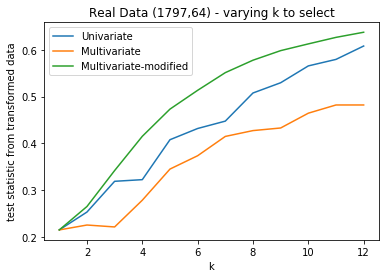

<Figure size 432x288 with 0 Axes>

In [49]:
import matplotlib.pyplot as plt
plt.plot(np.arange(12)+1,discrete_stats1)
plt.plot(np.arange(12)+1,discrete_stats2)
plt.plot(np.arange(12)+1,discrete_stats3)
plt.legend( ['Univariate', 'Multivariate', 'Multivariate-modified'])
plt.title('Real Data (1797,64) - varying k to select')
plt.xlabel('k')
plt.ylabel('test statistic from transformed data')
plt.figure()

In [119]:
from sklearn.datasets import load_wine
X, y = load_wine(return_X_y=True)
i = 1
discrete_stats1 = []
discrete_stats2 = []
discrete_stats3 = []
while i <= 11:
    uni = univariate_best(X,y,i)
    print(uni)
    discrete_stats1.append(k_sample_test(X[:,uni],y))
    print(k_sample_test(X[:,uni],y))
    X_1 = fit_transform(X,y,i)
    discrete_stats2.append(k_sample_test(X_1,y))
    print(k_sample_test(X_1,y))
    X_2 = fit_transform_modified(X,y,i)
    discrete_stats3.append(k_sample_test(X_2,y))
    print(k_sample_test(X_2,y))
    print(i)
    i = i +1

[6]
0.5932163626586545
[6]
0.5932163626586545
[6]
0.5932163626586545
1
[12  6]
0.5608606352422578
[6, 0]
0.7396316565487421
[6 0]
0.7396316565487421
2
[ 9 12  6]
0.5610365058132936
[6, 0, 10]
0.7537987995282948
[ 6  0 10]
0.7537987995282948
3
[ 0  9 12  6]
0.5609941242348996
[6, 0, 10, 2]
0.7625747523495765
[ 6  0 10  2]
0.7625747523495765
4
[11  0  9 12  6]
0.5610153948483216
[6, 0, 10, 2, 11]
0.764180295433276
[ 6  0 10  2 11]
0.764180295433276
5
[10 11  0  9 12  6]
0.5610176609889083
[6, 0, 10, 2, 11, 7]
0.7636628608803814
[ 6  0 10  2 11  7]
0.7636628608803814
6
[ 5 10 11  0  9 12  6]
0.5610256821145557
[6, 0, 10, 2, 11, 7, 5]
0.7421233049220645
[ 6  0 10  2 11  7  5]
0.7421233049220645
7
[ 1  5 10 11  0  9 12  6]
0.561066421730797
[6, 0, 10, 2, 11, 7, 5, 9]
0.7352641008848263
[ 6  0 10  2 11  7  5  9]
0.7352641008848263
8
[ 8  1  5 10 11  0  9 12  6]
0.561072241969486
[6, 0, 10, 2, 11, 7, 5, 9, 8]
0.7313323350241276
[ 6  0 10  2 11  7  5  9  8]
0.7313323350241276
9
[ 3  8  1  5 10

<Figure size 432x288 with 0 Axes>

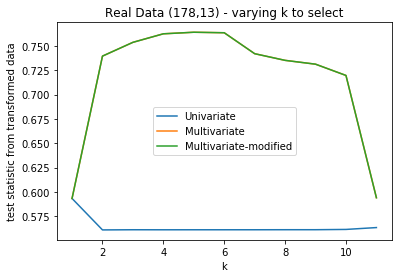

<Figure size 432x288 with 0 Axes>

In [127]:
import matplotlib.pyplot as plt
plt.plot(np.arange(11)+1,discrete_stats1)
plt.plot(np.arange(11)+1,discrete_stats2)
plt.plot(np.arange(11)+1,discrete_stats3)
plt.legend( ['Univariate', 'Multivariate', 'Multivariate-modified'])
plt.title('Real Data (178,13) - varying k to select')
plt.xlabel('k')
plt.ylabel('test statistic from transformed data')
plt.figure()

In [122]:
from hyppo.tools import step,spiral,multiplicative_noise
i = 1
stats1 = []
stats2 = []
stats3 = []
while i < 20:
    x1,y1 = step(100,i, noise = False)
    x2,y2 = multiplicative_noise(100,20-i)
    z1,w1 = spiral(100,i, noise = False)
    z2,w2 = multiplicative_noise(100,20-i)
    X = np.concatenate((x1,x2),axis = 1)
    Z = np.concatenate((z1,z2),axis = 1)
    X = np.concatenate((X,Z),axis = 0)
    y = np.concatenate((np.zeros(100),np.ones(100)))
    uni = univariate_best(X,y,5)
    print(uni)
    stat1 = k_sample_test(X[:,uni],y)
    print(stat1)
    stats1.append(stat1)
    norm = fit_transform(X,y,5)
    stat2 = k_sample_test(norm,y)
    print(stat2)
    stats2.append(stat2)
    mod = fit_transform_modified(X,y,5)
    stat3 = k_sample_test(mod,y)
    print(stat3)
    stats3.append(stat3)
    i = i + 1
x1,y1 = step(100,20, noise = False)
z1,w1 = spiral(100,20, noise = False)
X = np.concatenate((x1,z1),axis = 0)
y = np.concatenate((np.zeros(100),np.ones(100)))
uni = univariate_best(X,y,5)
print(uni)
stat1 = k_sample_test(X[:,uni],y)
print(stat1)
stats1.append(stat1)
norm = fit_transform(X,y,5)
stat2 = k_sample_test(norm,y)
print(stat2)
stats2.append(stat2)
mod = fit_transform_modified(X,y,5)
stat3 = k_sample_test(mod,y)
print(stat3)
stats3.append(stat3)

[13  3  9  7  0]
0.07507103446734668
[0, 3, 16, 19, 15]
0.09208787229155423
[7 0 2 9 5]
0.08994567601304126
[14 19 18  0  1]
0.15210233108296392
[1, 0, 14, 19, 5]
0.15269719081435243
[ 0  1 19 14  5]
0.1526971908143496
[ 9 12  1  0  2]
0.05938327757043347
[2, 1, 0, 5, 4]
0.08283197961009102
[1 0 2 5 4]
0.08283197961009103
[13  2  1  0  3]
0.13054194160757704
[3, 2, 0, 1, 7]
0.1467363401891831
[3 2 1 0 7]
0.14673634018918655
[1 2 3 0 4]
0.17547676247858082
[4, 3, 2, 0, 1]
0.17547676247858096
[3 0 4 2 1]
0.17547676247858096
[2 3 0 4 5]
0.22332664704341063
[5, 4, 2, 3, 0]
0.22332664704341063
[2 3 0 4 5]
0.22332664704341063
[1 4 0 5 6]
0.18431058885031354
[6, 5, 4, 3, 2]
0.2144199208144066
[0 5 6 2 4]
0.22299569496255733
[3 4 5 6 7]
0.26790544692213825
[7, 6, 4, 5, 3]
0.2679054469221374
[3 4 5 6 7]
0.26790544692213825
[4 5 6 8 7]
0.3045131864200344
[7, 6, 5, 4, 3]
0.34018072145105394
[7 6 5 4 3]
0.34018072145105394
[5 6 8 7 9]
0.36053091776100155
[9, 7, 8, 6, 5]
0.36053091776099777
[5 6 8 

<Figure size 432x288 with 0 Axes>

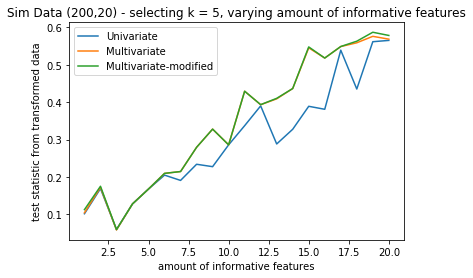

<Figure size 432x288 with 0 Axes>

In [104]:
plt.plot(np.arange(20)+1,stats1)
plt.plot(np.arange(20)+1,stats2)
plt.plot(np.arange(20)+1,stats3)
plt.legend( ['Univariate', 'Multivariate', 'Multivariate-modified'])
plt.title('Sim Data (200,20) - selecting k = 5, varying amount of informative features')
plt.xlabel('amount of informative features')
plt.ylabel('test statistic from transformed data')
plt.figure()

In [124]:
from hyppo.tools import rot_ksamp,logarithmic
i = 1
stats1 = []
stats2 = []
stats3 = []
while i < 20:
    x1,y1 = rot_ksamp("exponential",100,i,noise=False)
    x2,y2 = multiplicative_noise(200,20 - i)
    X = np.concatenate((x1,y1),axis = 0)
    X = np.concatenate((X,x2),axis = 1)
    y = np.concatenate((np.zeros(100),np.ones(100)))
    uni = univariate_best(X,y,5)
    print(uni)
    stat1 = k_sample_test(X[:,uni],y)
    print(stat1)
    stats1.append(stat1)
    norm = fit_transform(X,y,5)
    stat2 = k_sample_test(norm,y)
    print(stat2)
    stats2.append(stat2)
    mod = fit_transform_modified(X,y,5)
    stat3 = k_sample_test(mod,y)
    print(stat3)
    stats3.append(stat3)
    i = i + 1
x1,y1 = rot_ksamp("exponential",100,20,noise=False)
X = np.concatenate((x1,y1),axis = 0)
y = np.concatenate((np.zeros(100),np.ones(100)))
uni = univariate_best(X,y,5)
print(uni)
stat1 = k_sample_test(X[:,uni],y)
print(stat1)
stats1.append(stat1)
norm = fit_transform(X,y,5)
stat2 = k_sample_test(norm,y)
print(stat2)
stats2.append(stat2)
mod = fit_transform_modified(X,y,5)
stat3 = k_sample_test(mod,y)
print(stat3)
stats3.append(stat3)

[20 18 10  1  0]
0.6429628313456178
[0, 3, 14, 17, 20]
0.7541040762073824
[ 0 14 20  2 11]
0.7548671907846581
[16  6  7  1  0]
0.6865112302963751
[0, 1, 4, 9, 18]
0.7174103374847898
[ 1  0  4  8 18]
0.7175958778042892
[11 20 15 13  0]
0.660883640278092
[0, 1, 2, 13, 9]
0.6930772389947681
[ 0  2  1 13  9]
0.6930772389947717
[14  7 18  8  0]
0.6488502815955856
[0, 3, 1, 15, 2]
0.6832718261450221
[ 0  3  1 15 17]
0.6842131434399044
[15 19 20 16  0]
0.6336996343425435
[0, 1, 2, 3, 16]
0.6737169132990685
[16  0  1  3  2]
0.6737169132990749
[18  1  8  7  0]
0.6419120287442152
[0, 3, 4, 7, 12]
0.671705354631863
[7 0 3 2 4]
0.6750422104440503
[11 20 17 12  0]
0.6549966699663149
[0, 3, 6, 1, 2]
0.6947627041670641
[0 2 1 3 4]
0.6949315285845242
[16 13 19 15  0]
0.6829060631022624
[0, 7, 10, 3, 4]
0.7080511483320915
[ 0  7 10  3 11]
0.7083888643248174
[16 11 15 14  0]
0.6215762274777127
[0, 5, 3, 4, 6]
0.6559977917074585
[0 5 3 4 7]
0.658102212242137
[17 16 11 15  0]
0.6852760166671447
[0, 5, 3, 

<Figure size 432x288 with 0 Axes>

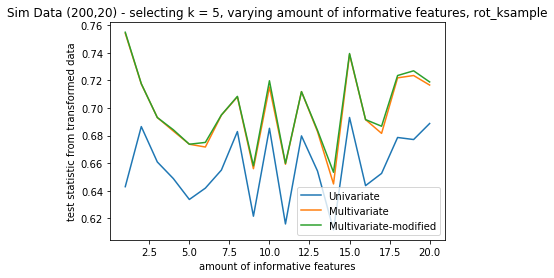

<Figure size 432x288 with 0 Axes>

In [125]:
plt.plot(np.arange(20)+1,stats1)
plt.plot(np.arange(20)+1,stats2)
plt.plot(np.arange(20)+1,stats3)
plt.legend( ['Univariate', 'Multivariate', 'Multivariate-modified'])
plt.title('Sim Data (200,20) - selecting k = 5, varying amount of informative features, rot_ksample')
plt.xlabel('amount of informative features')
plt.ylabel('test statistic from transformed data')
plt.figure()